In [1]:
#!/usr/bin/env python3

"""
A template example for GFO. This example uses a diabetes dataset found on kaggle.
Below is an example of how to use GFO to identify valuable features, reduce
dimentionality, and interpret results.
"""
from learner import GFO
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

# Load the raw data
raw_data = pd.read_csv('diabetes.csv')

# Develop our feature set matrix. We are given the features,
# Pregnancies
# Glucose
# Blood Pressure
# Skin Thickness
# Insulin
# BMI
# DiabetesPedigreeFunction
# Age

A = np.matrix(raw_data.loc[:, 'Pregnancies': 'Age'])

# The vector that contains our answer is the outcome vector.
b = np.matrix(raw_data['Outcome']).T

# Use GFO to attempt to learn about how the features in A determine
# the value of the answers in b.
x, r, steps = GFO(A, b).learn(lrs=2)

accuracy = 1 - (np.count_nonzero(np.rint(A*steps[-1]) - b) / len(b))
print('accuracy = ', accuracy)
print(steps[-1])
print(np.around(steps[-1], decimals=3))

global_epoch= 4 local plane= 0 res= 14.553121726818647
global_epoch= 19 local plane= 0 res= 12.188485786787682
accuracy =  0.7057291666666667
[[ 0.02352538]
 [ 0.00053692]
 [-0.00286443]
 [-0.00019524]
 [-0.00017644]
 [ 0.01022357]
 [ 0.16182921]
 [ 0.00054291]]
[[ 0.024]
 [ 0.001]
 [-0.003]
 [-0.   ]
 [-0.   ]
 [ 0.01 ]
 [ 0.162]
 [ 0.001]]


Pregnancies 0.006275644439273913
Glucose 0.0002943109090512777
BloodPressure 0.003069954361771199
SkinThickness 9.687442015287259e-06
Insulin 0.0004129411756543179
BMI 0.006488587271729557
DiabetesPedigreeFunction 0.002871215703640588
Age 4.0711615516693085e-05


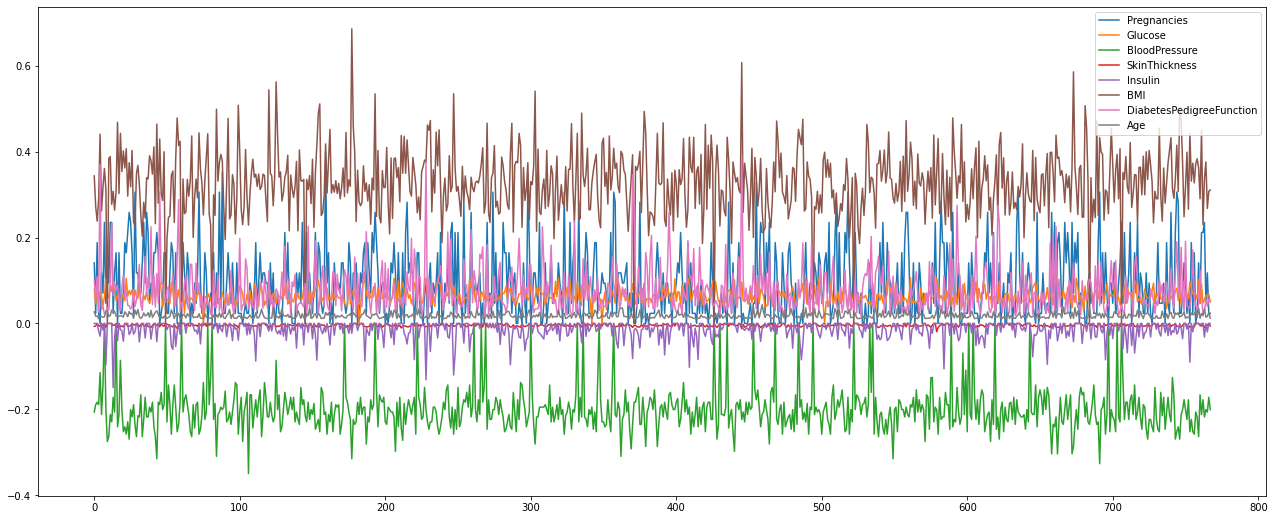

In [2]:
"""
Lets look at the answer

w = [[ 0.024]  - Pregnancies
     [ 0.001]  - Glucose
     [-0.003]  - Blood Pressure
     [-0.   ]  - Skin Thickness
     [-0.   ]  - Insulin
     [ 0.01 ]  - BMI
     [ 0.162]  - DiabetesPedigreeFunction
     [ 0.001]] - Age
     
Some of these values are 0 or close to 0. Is this a coincidence? Or is there something special.
We can look at the contributions of each feature by looking at |(sigma - mu)|/sqrt(len) to see 
"""

plt.figure(figsize=(22, 9))
for i in range(A.shape[1]):
    print(raw_data.columns[i], np.var(A[:, i]*x[i]))
    plt.plot(A[:, i]*x[i], label=raw_data.columns[i])
plt.legend()

In [ ]:
"""
Notice, the value for skin thickness is, 3.23695251148216e-05. This means that
skin thickness provides 0.00003 units to the final diabetes measure, or its contributions
are insignifiant. REmove features that provide little varience to the output.
"""

raw_data = pd.read_csv('diabetes.csv')
raw_data.pop('SkinThickness')
raw_data.pop('Age')
raw_data.pop('Insulin')
raw_data.pop('BloodPressure')

# Rerun the learner without the skinthickness
A = np.matrix(raw_data.loc[:, 'Pregnancies': 'DiabetesPedigreeFunction'])
b = np.matrix(raw_data['Outcome']).T
x, r, steps = GFO(A, b, lr=1e-4).learn(lrs=2)

accuracy = 1 - (np.count_nonzero(np.rint(A*steps[-1]) - b) / len(b))
print('accuracy = ', accuracy)
print(steps[-1])
print(np.around(steps[-1], decimals=3))

global_epoch= 6 local plane= 0 res= 12.064314715669497
